In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder 
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer 
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, mean_squared_error #roc_auc_score as AUC
from sklearn.externals import joblib

import pickle
import time
import os.path
import math


# Load Data

In [2]:
n_bytes = 2**31
max_bytes = 2**31 - 1

def load_pickle(file_path):
    
    bytes_in = bytearray(0)
    input_size = os.path.getsize(file_path)
    with open(file_path, 'rb') as f_in:
        for _ in range(0, input_size, max_bytes):
            bytes_in += f_in.read(max_bytes)
    
    return pickle.loads(bytes_in)

In [3]:
train = load_pickle('train_df_after_preprocessing.pkl') # balanced class
valid = load_pickle('valid_df_after_preprocessing.pkl')
test = load_pickle('test_df_after_preprocessing.pkl')

#train_click = train['click']
train_click = train['click']
train_bidprice = train['bidprice']
train_payprice = train['payprice']
#train_X = train.drop(['click', 'bidprice', 'payprice'], axis = 1)
train_X = train.drop(['click', 'bidprice', 'payprice'], axis = 1)

valid_click = valid['click']
valid_bidprice = valid['bidprice']
valid_payprice = valid['payprice']
valid_X = valid.drop(['click', 'bidprice', 'payprice'], axis = 1)

# GBDT+LR

In [4]:
from sklearn import metrics
# 导入数据  
# X = train.drop(['click','payprice','bidprice'], axis = 1) 
# y = train['click']
  
# 切分为测试集和训练集，比例0.5  
X_train, X_test, y_train, y_test = train_test_split(train_X, train_click, test_size=0.5)  
# 将训练集切分为两部分，一部分用于训练GBDT模型，另一部分输入到训练好的GBDT模型生成GBDT特征，然后作为LR的特征。这样分成两部分是为了防止过拟合。  
X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train, y_train, test_size=0.5)  
  
# 弱分类器的数目  
n_estimator = 10  
# 调用GBDT分类模型  
grd = GradientBoostingClassifier(n_estimators=n_estimator)  
  
# 调用one-hot编码。  
grd_enc = OneHotEncoder()  
  
# 调用LR分类模型。  
grd_lm = LogisticRegression()  
  
#使用X_train训练GBDT模型，后面用此模型构造特征  
grd.fit(X_train, y_train)  
  
#直接进行预测，查看AUC得分  
y_pred_grd = grd.predict_proba(X_test)[:, 1]  
fpr_grd, tpr_grd, _ = metrics.roc_curve(y_test, y_pred_grd)  
roc_auc = metrics.auc(fpr_grd, tpr_grd)  
print('predict',roc_auc)  
  
# fit one-hot编码器  
grd_enc.fit(grd.apply(X_train)[:, :, 0])  
  
#使用训练好的GBDT模型构建特征，然后将特征经过one-hot编码作为新的特征输入到LR模型训练。  
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)  
  
# 用训练好的LR模型多X_test做预测  
y_pred_grd_lm = grd_lm.predict_proba(grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]  
  
# 根据预测结果输出  
fpr_grd_lm, tpr_grd_lm, _ = metrics.roc_curve(y_test, y_pred_grd_lm)  
roc_auc = metrics.auc(fpr_grd_lm, tpr_grd_lm)  
print('predict',roc_auc)
  
print("AUC Score :",(metrics.roc_auc_score(y_test, y_pred_grd_lm)))    

y_pred_grd_lm

predict 0.776696280812
predict 0.783526198564
AUC Score : 0.783526198564


array([ 0.97703227,  0.82115283,  0.22400646, ...,  0.49583805,
        0.31357197,  0.89304027])

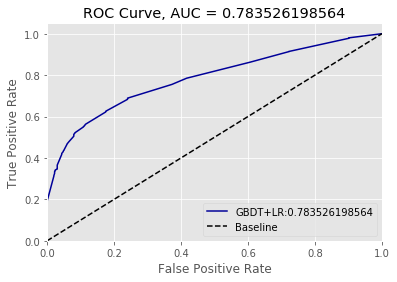

In [5]:
with plt.style.context(('ggplot')):
    fig, ax = plt.subplots()
    ax.plot(fpr_grd_lm, tpr_grd_lm, "#000099", label='GBDT+LR:'+str(roc_auc))
    ax.plot([0, 1], [0, 1], 'k--', label='Baseline')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.title('ROC Curve, AUC = '+str(roc_auc))

In [6]:
joblib.dump(grd_lm, 'GBDT+LR' + ".pickle.dat" )

['GBDT+LR.pickle.dat']

In [7]:
model = joblib.load("GBDT+LR.pickle.dat")
valid_ctr_prediction=model.predict_proba(grd_enc.transform(grd.apply(valid_X)[:, :, 0]))[:, 1]  

# Prediction

In [8]:
pCTR = valid_ctr_prediction
bid_price = [1644*p for p in pCTR]
auction = bid_price >= valid_payprice
win_bid_ix = [index for index,auc in enumerate(auction) if auc]

clicks = sum(valid_click[win_bid_ix])
spend = sum(valid_payprice[win_bid_ix])
num_impress = len(win_bid_ix)

sorted_pCTR_index = sorted(range(len(auction)), key=lambda k:pCTR[k])

In [9]:
auction = bid_price >= valid_payprice
win_bid_ix = [ index for index,auc in enumerate(auction) if auc ]
bid_spends = valid_payprice[win_bid_ix].values
bid_clicks = valid_click[win_bid_ix].values

budget = 6250000
current_spend = sum(bid_spends)

total_bids = len(bid_spends)

for i in range(len(bid_spends)):
    
    current_spend -= bid_spends[total_bids-i-1]
    
    if current_spend <= budget:
        break

final_win_bid_ix = win_bid_ix[:(total_bids - i -1)]
bid_spends = sum(valid_payprice[final_win_bid_ix].values)
bid_clicks = sum(valid_click[final_win_bid_ix].values)

In [10]:
sum(valid_payprice[win_bid_ix[:302377]]) <= budget

False

In [11]:
def EvaluateClick( bid_price, budget, valid_payprice, valid_click):
    
    auction = bid_price >= valid_payprice
    win_bid_ix = [ index for index,auc in enumerate(auction) if auc ]
    bid_spends = valid_payprice[win_bid_ix].values
    bid_clicks = valid_click[win_bid_ix].values

    budget = 6250000
    current_spend = sum(bid_spends)

    total_bids = len(bid_spends)

    for i in range(len(bid_spends)):

        current_spend -= bid_spends[total_bids-i-1]

        if current_spend <= budget:
            break

    final_win_bid_ix = win_bid_ix[:(total_bids - i -1)]
    bid_spends = sum(valid_payprice[final_win_bid_ix].values)
    bid_clicks = sum(valid_click[final_win_bid_ix].values)
    
    print('clicks:', bid_clicks, 'impressions:', len(final_win_bid_ix), 'spend:', bid_spends)

    return bid_clicks


# bid_price = 1644*valid_ctr_prediction[:,1]
# EvaluateClick( bid_price, 6250000, valid_payprice, valid_click);

clicks: 102 impressions: 114964 spend: 3781995
clicks: 102 impressions: 115043 spend: 3791435
clicks: 102 impressions: 115576 spend: 3822170
clicks: 104 impressions: 119771 spend: 4036707
clicks: 104 impressions: 120149 spend: 4060262
clicks: 106 impressions: 120528 spend: 4079214
clicks: 109 impressions: 123823 spend: 4327582
clicks: 109 impressions: 124651 spend: 4372799
clicks: 109 impressions: 124842 spend: 4388775
clicks: 109 impressions: 125867 spend: 4449555
clicks: 109 impressions: 126323 spend: 4475119
clicks: 110 impressions: 126950 spend: 4505617
clicks: 111 impressions: 128098 spend: 4595879
clicks: 111 impressions: 128911 spend: 4648437
clicks: 112 impressions: 129195 spend: 4672644
clicks: 112 impressions: 129478 spend: 4695516
clicks: 112 impressions: 130090 spend: 4729961
clicks: 112 impressions: 130576 spend: 4758157
clicks: 114 impressions: 132960 spend: 4896092
clicks: 114 impressions: 133121 spend: 4912930
clicks: 116 impressions: 133727 spend: 4948436
clicks: 116 i

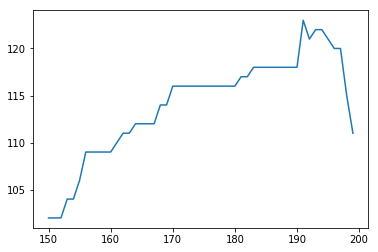

In [12]:
# search the best base_price

base_prices = np.arange(150,200,1)
clicks = []
budget = 6250000

for base in base_prices:
    
    pCTR = valid_ctr_prediction
    bid_price = base*pCTR
    c = EvaluateClick( bid_price, budget, valid_payprice, valid_click);
    clicks.append(c)

    
plt.figure()
plt.plot(base_prices, clicks)
print('best constant:', base_prices[clicks.index(max(clicks))])

In [13]:
### prediction
test_prediction = model.predict_proba(grd_enc.transform(grd.apply(test)[:, :, 0]))[:, 1]
bid_price = [int(185*t) for t in test_prediction]

submission = pd.read_csv('Group_xx.csv')
submission['bidprice'] = bid_price
submission.to_csv('Group_9.csv')

In [14]:
max(submission['bidprice'])

183

In [15]:
test_prediction

array([ 0.60051148,  0.89984265,  0.31357197, ...,  0.22400646,
        0.4279537 ,  0.57645574])